A Carteira 4Fundos EW é composta por:

    * 25% Fidelity Global Cnsmr Inds A-Dis-EUR LU0114721508
    * 25% GS Glb SmCp CORE® Eq E EUR Acc Close LU0245181838
    * 25% M&G Optimal Income Euro A-H Acc GB00B1VMCY93
    * 25% PIMCO GIS Global Bond E Acc EUR H IE00B11XZ103

O BR_Mod é o BSF Managed Index Port Mod A2RF EUR LU1241524708, que é um fundo de ETFs e está aqui a servir de benchmark

In [18]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.plotly as py
import plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
from time import gmtime, strftime
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [19]:
%%capture
import cufflinks as cf
cf.go_offline()

In [20]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2017-11-14 02:58:54


In [21]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [22]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2015-06-03"
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

MSid = ['F0GBR04EAN', 'F000000FH0', 'F0000007LD', "F0GBR06T61", 'F00000VYLT']
Nomes = ['FCI','GS_SC', 'MG_OI', 'PimcoGB', 'BR_Mod']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

# Filtering dataframe from Begin to END
# fundos = fundos.loc[:End] # Só activas se quiseres que acabe num dia especifíco

In [23]:
#### Returns ####
returns = (fundos / fundos.shift(1)) - 1

In [24]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)

In [25]:
round(fundos_norm, 2).iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

In [26]:
### weights ####
weights1 = np.array([0.25, 0.25, 0.25, 0.25, 0])
weights2 = np.array([0, 0, 0, 0, 1])

#### Fazer um dataframe vazio ####
novos_portfolios = fundos.copy().drop(fundos[:len(fundos.columns) - 1], axis=1)

### Calculate Portfolio value with linear algebra ####
novos_portfolios['4Fundos'] = np.dot(fundos_norm, weights1) # weights1 * quotes1
novos_portfolios['BR_Mod']  = np.dot(fundos_norm, weights2) # weights2 * quotes2

# arredondar 
novos_portfolios['4Fundos'] = round(novos_portfolios['4Fundos'], 2)

In [27]:
novos_portfolios.iplot(yTitle='Valor por cada 100€ investidos',
                       title='4Fundos EW vs Blackrock Moderate (Benchmark)')

In [28]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(novos_portfolios), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

In [29]:
#### Returns ####
returns = (novos_portfolios / novos_portfolios.shift(1)) - 1

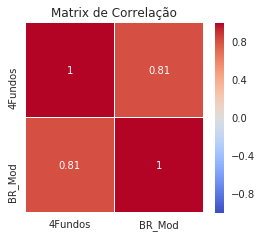

In [30]:
##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = returns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(4, 3.5) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin = -1)
plt.title('Matrix de Correlação')
plt.show()

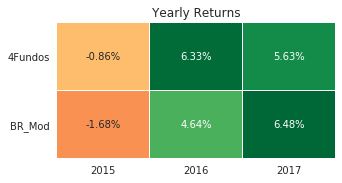

In [31]:
# Resampling to yearly (business year)
yearly_quotes = novos_portfolios.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([novos_portfolios.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2014, 2018))]).drop(2014)
returns.columns = ['4Fundos', 'BR_Mod']

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 2.5) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()

In [32]:
ratio = novos_portfolios['4Fundos'] / novos_portfolios['BR_Mod']
ratio.iplot(title ='Ratio between 4FundosEW and Blackrock Moderate')